In [1]:
from prophet import Prophet
import matplotlib.pyplot as plt

In [3]:
import pandas as pd

In [4]:
df_final=pd.read_csv("../../data/silver/master_weather_merged/toronto_master_weather_merged.csv")

In [5]:
train_df = df_final[df_final['ds'] < '2024-01-01'].copy()
test_df = df_final[df_final['ds'] >= '2024-01-01'].copy()

print(f"Training Weeks: {len(train_df)}")
print(f"Testing Weeks: {len(test_df)}")

Training Weeks: 521
Testing Weeks: 93


In [6]:
m = Prophet(yearly_seasonality=True, weekly_seasonality=False)

In [7]:
m.add_country_holidays(country_name='CA')

In [8]:
print("Training Prophet model...")
m.fit(train_df[['ds', 'y']])

16:55:55 - cmdstanpy - INFO - Chain [1] start processing
16:55:55 - cmdstanpy - INFO - Chain [1] done processing


Training Prophet model...


In [9]:
future = m.make_future_dataframe(periods=len(test_df), freq='W-MON')
forecast = m.predict(future)

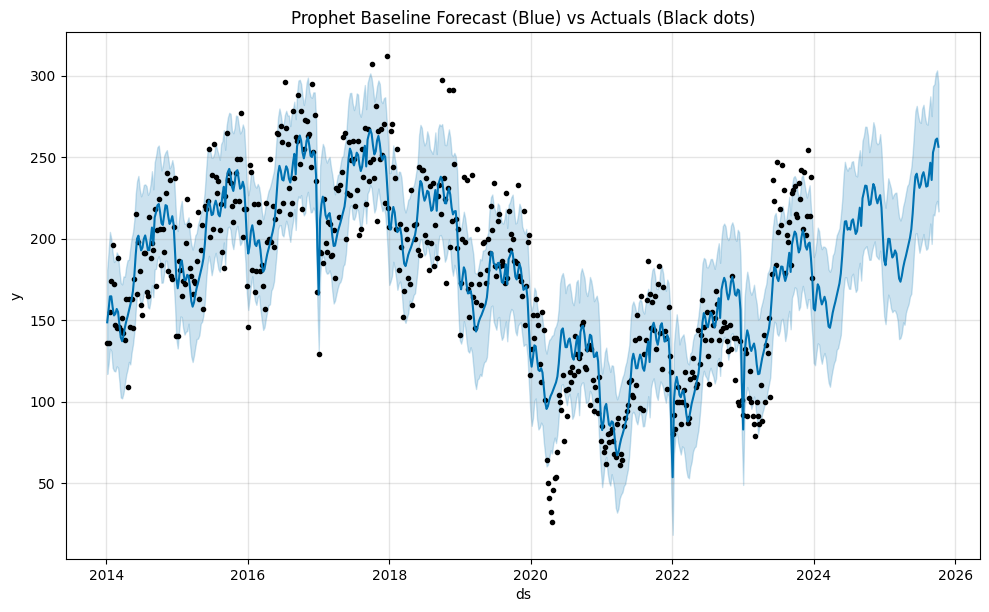

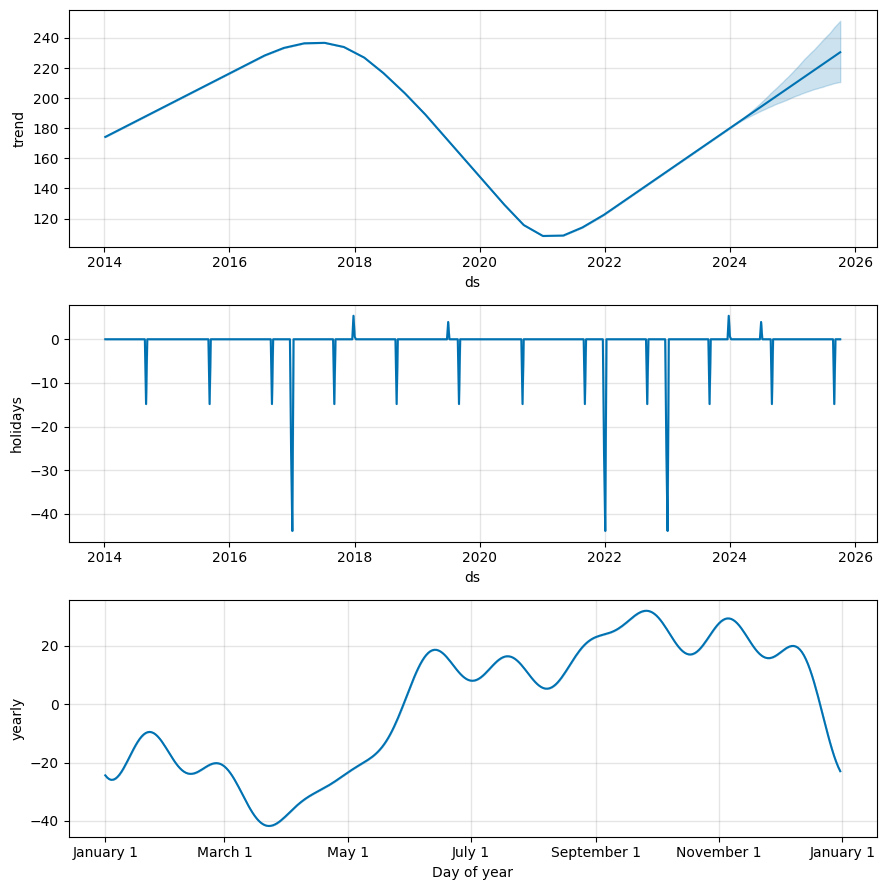

In [10]:

fig1 = m.plot(forecast)
plt.title("Prophet Baseline Forecast (Blue) vs Actuals (Black dots)")
plt.show()

fig2 = m.plot_components(forecast)
plt.show()

In [12]:
df_dashboard = test_df.copy().reset_index(drop=True)
forecast_subset = forecast[forecast['ds'].isin(df_dashboard['ds'])].reset_index(drop=True)

C:\Users\rajpu\AppData\Local\Temp\ipykernel_63816\2093240721.py:2: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  forecast_subset = forecast[forecast['ds'].isin(df_dashboard['ds'])].reset_index(drop=True)


In [13]:
df_dashboard['final_demand_forecast'] = forecast_subset['yhat']

In [14]:
df_dashboard['supply_capacity'] = 100.0

In [15]:
def get_seasonal_factor(date):
    # Convert string to datetime if needed
    d = pd.to_datetime(date)
    month = d.month
    day = d.day
    
    # "The Seasonality of Altruism" 
    if month == 12 and day > 20: 
        return 0.85  # December Dip (Holiday Travel)
    elif month in [7, 8]: 
        return 0.90  # Summer Lull (Cottage Season)
    elif month == 1: 
        return 1.10  # New Year Resolution Surge
    else: 
        return 1.0   # Normal Baseline

In [16]:
df_dashboard['seasonal_factor'] = df_dashboard['ds'].apply(get_seasonal_factor)

In [17]:
if 'is_holiday' in df_dashboard.columns:
    df_dashboard['holiday_penalty'] = df_dashboard['is_holiday'].apply(lambda x: 0.80 if x == 1 else 1.0)
else:
    df_dashboard['holiday_penalty'] = 1.0

In [18]:
df_dashboard['projected_supply'] = (
    df_dashboard['supply_capacity'] * df_dashboard['seasonal_factor'] * df_dashboard['holiday_penalty']
)

In [19]:
scaling_factor = df_dashboard['projected_supply'].mean() / df_dashboard['final_demand_forecast'].mean()
df_dashboard['scaled_demand'] = df_dashboard['final_demand_forecast'] * scaling_factor

df_dashboard['RCR'] = df_dashboard['projected_supply'] / df_dashboard['scaled_demand']

In [20]:
def get_status(rcr):
    if rcr < 1.0: 
        return 'RED'      # Deficit: Code Red
    elif rcr < 1.2: 
        return 'YELLOW'   # Warning: Tight Inventory
    else: 
        return 'GREEN'    # Stable: Good Coverage

In [21]:
df_dashboard['risk_status'] = df_dashboard['RCR'].apply(get_status)

In [23]:
df_dashboard.head()

,Unnamed: 0,ds,y,national_index,week_of_year,is_holiday,precip_mm,snow_depth_cm,min_temp,final_demand_forecast,supply_capacity,seasonal_factor,holiday_penalty,projected_supply,scaled_demand,RCR,risk_status
0,521,2024-01-01,182,5303.285714,1,1,29.4,0.2,-3.7,157.109086,100.0,1.1,0.8,88.0,75.057932,1.172428,YELLOW
1,522,2024-01-08,170,20238.125000,2,0,4.2,0.4,-6.2,155.869397,100.0,1.1,1.0,110.0,74.465677,1.477191,GREEN
2,523,2024-01-15,169,1743.250000,3,0,54.6,0.5,-13.6,164.810307,100.0,1.1,1.0,110.0,78.737144,1.397053,GREEN
3,524,2024-01-22,193,0.000000,4,0,3.2,0.3,-15.5,171.932278,100.0,1.1,1.0,110.0,82.139624,1.339183,GREEN
4,525,2024-01-29,196,700.500000,5,0,37.4,0.3,-1.9,170.191124,100.0,1.1,1.0,110.0,81.307797,1.352884,GREEN


In [22]:
export_cols = [
    'ds', 'y', 'final_demand_forecast', 'scaled_demand', 
    'projected_supply', 'RCR', 'risk_status'
]

In [24]:
import os
os.makedirs('../../data/gold', exist_ok=True)

output_path = '../../data/gold/risk_monitor_dashboard.csv'
df_dashboard[export_cols].to_csv(output_path, index=False)

## above is the export pipline based on the forecast data gotten from prophet model






















# Used xgboost to improve perfomance and also genetic algorithm to optimize hyperparametes but reseult were insiginificant non improvemental since the data used uses weekly data it smoothes day to day data so will only use prohet as selected model

In [11]:
train_pred = m.predict(train_df[['ds']])
train_df['prophet_pred'] = train_pred['yhat'].values

In [ ]:
train_df['residual'] = train_df['y'] - train_df['prophet_pred']

In [ ]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error

In [ ]:
features = ['national_index', 'is_holiday', 'precip_mm', 'snow_depth_cm', 'min_temp']
target = 'residual'

In [ ]:
xgb_model = xgb.XGBRegressor(
    n_estimators=475, 
    learning_rate=0.07064087638662711, 
    max_depth=3,
    random_state=42
)

In [ ]:
xgb_model.fit(train_df[features], train_df[target])
train_correction = xgb_model.predict(train_df[features])
mae_residual = mean_absolute_error(train_df['residual'], train_correction)
print(f"XGBoost MAE on Residuals: {mae_residual:.2f}")

In [ ]:
print("Generating Final Hybrid Forecast...")

# 1. Get Prophet Baseline for Test Set (2024-2025)
future_test = m.predict(test_df[['ds']])
test_df['prophet_pred'] = future_test['yhat'].values

# 2. Get XGBoost Correction for Test Set
# It looks at the weather/national data for 2024-2025 to predict shocks
test_df['xgb_correction'] = xgb_model.predict(test_df[features])

# 3. Combine: Final = Baseline + Correction [cite: 133]
test_df['final_prediction'] = test_df['prophet_pred'] + test_df['xgb_correction']

# 4. Compare Accuracy (Baseline vs Hybrid)
mae_base = mean_absolute_error(test_df['y'], test_df['prophet_pred'])
mae_hybrid = mean_absolute_error(test_df['y'], test_df['final_prediction'])

print(f"Baseline MAE: {mae_base:.2f}")
print(f"Hybrid MAE:   {mae_hybrid:.2f}")
print(f"Improvement:  {((mae_base - mae_hybrid) / mae_base) * 100:.1f}%")

# 5. Visualize the "Correction Effect"
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(test_df['ds'], test_df['y'], 'k.', label='Actual Demand')
plt.plot(test_df['ds'], test_df['prophet_pred'], 'b--', alpha=0.5, label='Prophet Baseline')
plt.plot(test_df['ds'], test_df['final_prediction'], 'r-', label='Hybrid Prediction')
plt.legend()
plt.title("The Hybrid Effect: Correcting the Baseline")
plt.show()

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous, Integer, Categorical
from sklearn.metrics import mean_squared_error

In [ ]:
X, y = make_regression(n_samples=1000, n_features=20, noise=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
base_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_jobs=-1,  # Use all CPU cores
    random_state=42
)

In [ ]:
param_grid = {
    # Tuning 'n_estimators' (Trees): Search between 50 and 500
    'n_estimators': Integer(50, 500),
    
    # Tuning 'learning_rate': Search continuously between 0.01 and 0.3
    # 'log-uniform' is better for learning rates to explore small values more thoroughly
    'learning_rate': Continuous(0.01, 0.3, distribution='log-uniform'),
    
    # Tuning 'max_depth': Search integers between 3 and 10
    'max_depth': Integer(3, 10),
    
    # Adding a few critical XGBoost parameters for better generalization
    'min_child_weight': Integer(1, 10),
    'subsample': Continuous(0.6, 1.0),
    'colsample_bytree': Continuous(0.6, 1.0)
}

In [ ]:
evolved_estimator = GASearchCV(
    estimator=base_model,
    cv=3,                            # 3-fold Cross-Validation
    scoring='neg_mean_squared_error',# Optimization metric (maximize negative MSE)
    population_size=20,              # Number of models per generation
    generations=15,                  # How many times to evolve
    param_grid=param_grid,
    n_jobs=-1,                       # Parallel processing
    verbose=True,                    # Show progress log
    keep_top_k=2                     # Elitism: Keep the 2 best models every generation
)

In [ ]:
print("Starting Genetic Algorithm evolution...")
evolved_estimator.fit(X_train, y_train)

# 6. Results
print("\nBest Parameters Found:")
print(evolved_estimator.best_params_)

# Evaluate on test data
y_pred = evolved_estimator.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")

In [ ]:
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Continuous, Integer
from sklearn.model_selection import KFold
import xgboost as xgb

print("Starting Genetic Optimization for Hybrid Model...")

# 1. Prepare Data
# We are training ONLY on the residuals (the errors Prophet made)
features = ['national_index', 'is_holiday', 'precip_mm', 'snow_depth_cm', 'min_temp']
X_train = train_df[features]
y_train = train_df['residual']

# 2. Define the Hyperparameter Space
# We include regularization (gamma, reg_alpha) to stop overfitting
param_grid = {
    'n_estimators': Integer(50, 300),              # Fewer trees to prevent memorization
    'learning_rate': Continuous(0.01, 0.2),        # Slower learning
    'max_depth': Integer(2, 6),                    # Shallower trees (less complex)
    'min_child_weight': Integer(1, 10),            # Conservative leaf nodes
    'subsample': Continuous(0.7, 1.0),             # Randomly sample rows
    'reg_alpha': Continuous(0.0, 1.0),             # L1 Regularization (Key for noise)
    'reg_lambda': Continuous(1.0, 3.0)             # L2 Regularization
}

# 3. Setup the Base Model
base_model = xgb.XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=42)

# 4. Configure Evolution
# We use K-Fold cross-validation to ensure the model generalizes well
cv_strategy = KFold(n_splits=3, shuffle=True, random_state=42)

evolved_estimator = GASearchCV(
    estimator=base_model,
    cv=cv_strategy,
    scoring='neg_mean_absolute_error', # Optimize for MAE (same as your metric)
    population_size=15,
    generations=10,
    param_grid=param_grid,
    n_jobs=-1,
    verbose=True,
    keep_top_k=2
)

# 5. Evolve!
evolved_estimator.fit(X_train, y_train)

print("\n--- OPTIMIZATION COMPLETE ---")
print("Best Parameters Found:")
print(evolved_estimator.best_params_)

# ---------------------------------------------------------
# STEP 3: RE-TEST WITH EVOLVED MODEL
# ---------------------------------------------------------
print("\nRe-evaluating Hybrid Performance...")

# Get predictions using the new "Best" model
test_correction = evolved_estimator.predict(test_df[features])

# Calculate new Final Prediction
test_df['evolved_prediction'] = test_df['prophet_pred'] + test_correction

# Measure New Accuracy
mae_base = mean_absolute_error(test_df['y'], test_df['prophet_pred'])
mae_evolved = mean_absolute_error(test_df['y'], test_df['evolved_prediction'])

print(f"Baseline MAE: {mae_base:.2f}")
print(f"Evolved Hybrid MAE: {mae_evolved:.2f}")

if mae_evolved < mae_base:
    diff = mae_base - mae_evolved
    print(f"SUCCESS: Hybrid model is now better by {diff:.2f} points (+{(diff/mae_base)*100:.1f}%)")
else:
    print("result: Model is still aggressive. We may need to drop noisy features.")